In [1]:
import os
import image_masking as im
import importlib

In [123]:
importlib.reload(im)

<module 'image_masking' from 'c:\\Users\\Jonathan\\Documents\\Informatica\\Big Data\\big-data-science-project\\image_segmentation\\image_masking.py'>

In [3]:
spark = im.init_spark_session()

In [55]:
path = '../data/'
fileLimit = 2
channel = 2

In [56]:
df = im.load_dataframe(spark, path, fileLimit)

In [57]:
row = df.take(1)[0]

In [58]:
from pyspark.ml.clustering import KMeans

In [124]:
kmeans = KMeans(k=2)
kmeans.setSeed(1)
kmeans.setMaxIter(10)

kmeans.setWeightCol("weighCol")

KMeans_b4a8d3a0fae0

In [125]:
import matplotlib.pyplot as plt

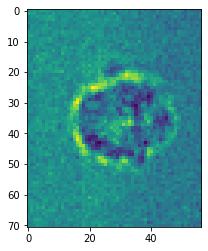

In [126]:
image = im.row_to_image(row, channel)
plt.imshow(image)

In [127]:
image_df = im.image_to_df(image, spark)

In [128]:
model = kmeans.fit(image_df)
model.setPredictionCol("newPrediction")

KMeansModel: uid=KMeans_b4a8d3a0fae0, k=2, distanceMeasure=euclidean, numFeatures=3

In [129]:
transformed = model.transform(image_df).select("features", "newPrediction")
rows = transformed.collect()

In [130]:
import numpy as np
pred_mask = np.reshape([r.newPrediction for r in rows], (row.width,row.height))

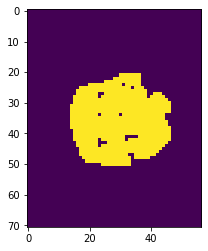

In [131]:
plt.imshow(im.row_to_mask(row, channel))

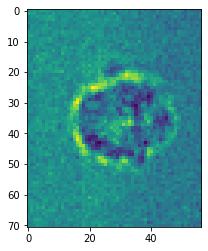

In [132]:
plt.imshow(im.row_to_image(row, channel))

In [133]:
opened_mask = im.apply_opening(pred_mask)

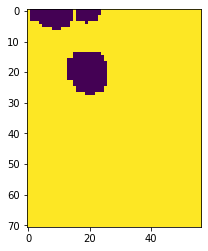

In [134]:
plt.imshow(opened_mask)

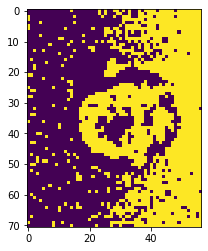

In [135]:
plt.imshow(pred_mask)

In [136]:
accuracy = (im.row_to_mask(row) == opened_mask).mean()
accuracy

0.08673091178650852

In [138]:
from sklearn.cluster import DBSCAN

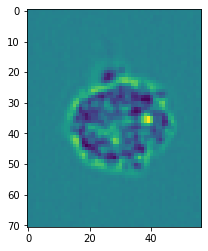

In [277]:
row = df.take(1)[0]
channel = 0
image = im.row_to_image(row, channel)
plt.imshow(image)

In [278]:
image_features = np.array([[index[0], index[1], p] for index, p in np.ndenumerate(image)])

In [389]:
clustering = DBSCAN(eps=2.5, min_samples=1).fit(image_features)

In [390]:
clustering.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [391]:
clustering_image = np.reshape(clustering.labels_, image.shape)

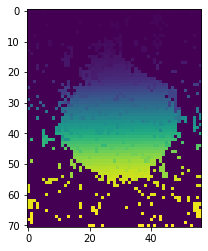

In [392]:
plt.imshow(clustering_image)